# Introduction

The goal of this document is to guide the reader through the process of creating a good model for predicting on a specific data set. The data set in this case is company data which assesses the quality of the online advertisment campaign and wants to predict wheter a customer subscribes or not. 

## Imports

To assess this certain python packages are needed which are loaded below.

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures


## Description of data set

A company wants to assess the quality of their online advertisement campaign. Online users are the main interest
in this campaign. The users see a web banner during their browsing activity. For each user, they want to be able
to predict whether they subscribe to the advertised product through the advertisement banner, based on the
information they have about them. To subscribe, the user has to click on the banner and then subscribe to the
service. The target variable name is subscription

# Exploratory data analysis (EDA) and feature engineering (FE)

In a first part we do EDA before we have a look at FE.

## EDA

First of all one needs to load the data and have a look over it. 

In [89]:
train = pd.read_csv('data/MLUnige2023_subscriptions_train.csv', index_col='Id', na_values='na', header=0)
train

,age,job,marital,education,device,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,outcome_old,X1,X2,X3,X4,subscription
Id,,,,,,,,,,,,,,,,,
0,28,freelance,married,grad_school,smartphone,4,2,26.80,3,4,196,failure,0,0,1,0.072803,1
1,48,industrial_worker,married,university,smartphone,30,4,13.05,1,1,79,success,0,0,0,0.075454,1
2,27,teacher,married,university,smartphone,14,7,8.10,3,0,-1,NaN,0,1,1,0.068110,0
3,44,unemployed,divorced,university,smartphone,13,5,7.10,2,1,369,other,0,0,1,0.091942,0
4,29,manager,single,grad_school,smartphone,26,4,15.90,2,2,143,success,0,0,0,0.085922,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8947,54,industrial_worker,married,university,smartphone,16,7,7.30,1,0,-1,NaN,1,0,0,0.072803,0
8948,43,industrial_worker,married,university,smartphone,4,2,37.75,2,0,-1,NaN,0,0,1,0.081456,1
8949,27,manager,single,grad_school,NaN,5,6,29.00,3,0,-1,NaN,0,0,1,0.079186,1


Just by looking over the first few rows of the data one can see that there are different data types in the data. The columns age, time_spent, banner_views, banner_views_old, days_elapsed_old and X4 are numerical columns, while job, martial, education and device are nominal categorical data. X1, X2, X3 and the target variable subscription are meanwhile boolean. Meanwhile there can be a debate about what type of data the day and month column are. Together these two columns can represent the date where the data was recorded but the columns alone may be good categorical ordinal data. In this case we will use them as categorical data. We will also now seperate the subscription from the predictors. 

In [90]:
# train 
train = train.astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'bool', 'X2':'bool', 'X3':'bool', 'X4':'float64', 'subscription':'bool', 'day':'category', 'month':'category'})
y_train = train.subscription
train = train.drop(columns=['subscription'])
train.day = pd.Categorical(train.day, ordered=True)
train.month = pd.Categorical(train.month, ordered=True) 
# train['date'] = train[['day', 'month']].apply(lambda x: datetime.datetime(year=2022, month=x['month'], day=x['day']).strftime('%Y-%m-%d'), axis=1)

# test
test = pd.read_csv('data/MLUnige2023_subscriptions_test.csv', index_col='Id', na_values='na', header=0)
test = test.astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'bool', 'X2':'bool', 'X3':'bool', 'X4':'float64', 'day':'category', 'month':'category'})
test.day = pd.Categorical(test.day, ordered=True)
test.month = pd.Categorical(test.month, ordered=True) 
# test['date'] = test[['day', 'month']].apply(lambda x: datetime.datetime(year=2022, month=x['month'], day=x['day']).strftime('%Y-%m-%d'), axis=1)

As numerical and categorical data sometimes needs to be treated differently we will extract the names of the columns which are categorical or numerical

In [91]:
categorical_columns = train.select_dtypes(include=["category","bool", "object"])
categorical_columns_names = list(categorical_columns.columns)
numerical_columns = train.select_dtypes(exclude=["category","bool", "object"])
numerical_columns_names = list(numerical_columns)

To check whether all the changes were implemented one can check by using the info command. 

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8952 entries, 0 to 8951
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               8952 non-null   int64   
 1   job               8891 non-null   category
 2   marital           8952 non-null   category
 3   education         8574 non-null   category
 4   device            6902 non-null   category
 5   day               8952 non-null   category
 6   month             8952 non-null   category
 7   time_spent        8952 non-null   float64 
 8   banner_views      8952 non-null   int64   
 9   banner_views_old  8952 non-null   int64   
 10  days_elapsed_old  8952 non-null   int64   
 11  outcome_old       2148 non-null   category
 12  X1                8952 non-null   bool    
 13  X2                8952 non-null   bool    
 14  X3                8952 non-null   bool    
 15  X4                8952 non-null   float64 
dtypes: bool(3), category(7),

We see that all of the columns have the expeceted data type. We also see that there are some missing values. For the numerical data we can use describe to see the ranges of the data. 

In [93]:
train.describe()

,age,time_spent,banner_views,banner_views_old,days_elapsed_old,X4
count,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000
mean,41.201743,17.130306,2.540550,0.759160,49.403262,0.086603
std,11.638321,16.902741,2.824065,2.099277,107.365840,0.030253
min,18.000000,0.000000,1.000000,0.000000,-1.000000,0.000000
25%,32.000000,6.100000,1.000000,0.000000,-1.000000,0.073891
50%,39.000000,11.450000,2.000000,0.000000,-1.000000,0.077661
75%,49.000000,22.500000,3.000000,0.000000,-1.000000,0.087768
max,95.000000,245.400000,63.000000,58.000000,854.000000,0.810043


It is interesting in the data is that minimum value of the columns. We see that the minimum age is at 18 which inquires that to subscribe for this service one has to be at least 18 years old. To us it seems alright that one can spend 0 time on something but it is rather intriguing, that the banner_views start at 1 while the banner_views_old start at 0. Maybe there was a measurement change or similar. It shouldn't matter too much for any predictions but it is something to note. Meanwhile the days_elasped_old column seems to be more of a problem. There the data starts at -1 which makes no sense. One could now add 1 to this data but looking at the whole data it gets clear that this does not make any sense.

C:\Users\micha\AppData\Local\Temp\ipykernel_6508\2366037970.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  val_counts_days_elapsed_old = train.days_elapsed_old.value_counts()[:10].plot(kind='barh')


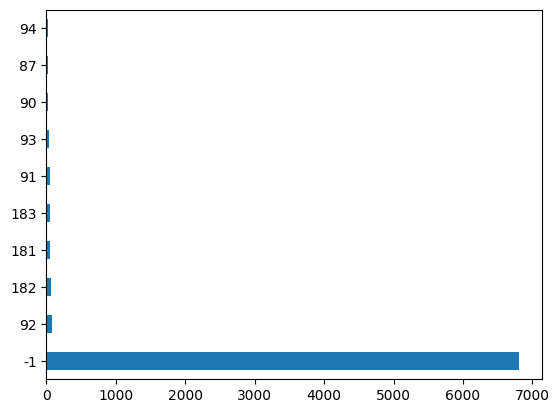

In [94]:
val_counts_days_elapsed_old = train.days_elapsed_old.value_counts()[:10].plot(kind='barh')


One can clearly see that -1 seems to be the most occuring value. As it is a days elapsed value our guess is that this data is inclompete and missing. Therefore one for sure needs to treat it as NA and impute it. Here we replace the -1 values as NA.

In [95]:
train = train.replace(-1, np.nan)
test = test.replace(-1, np.nan)
train.describe()

,age,time_spent,banner_views,banner_views_old,days_elapsed_old,X4
count,8952.000000,8952.000000,8952.000000,8952.000000,2149.000000,8952.000000
mean,41.201743,17.130306,2.540550,0.759160,208.962773,0.086603
std,11.638321,16.902741,2.824065,2.099277,120.495410,0.030253
min,18.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,32.000000,6.100000,1.000000,0.000000,99.000000,0.073891
50%,39.000000,11.450000,2.000000,0.000000,183.000000,0.077661
75%,49.000000,22.500000,3.000000,0.000000,300.000000,0.087768
max,95.000000,245.400000,63.000000,58.000000,854.000000,0.810043


Now the days_elapsed_old column makes more sense. We also see that the numerical data are on different scales which means that we have to standardize them. 

In [96]:
scaler = StandardScaler()
scaler.fit(train[numerical_columns_names])
train[numerical_columns_names] = pd.DataFrame(scaler.transform(train[numerical_columns_names]))
test[numerical_columns_names] = pd.DataFrame(scaler.transform(test[numerical_columns_names]))

### Missing Data

As we have seen we have a lot of missig values in the categorical data and in one column of the numerical data. Therefore we need to look at the missing values. 

<Axes: >

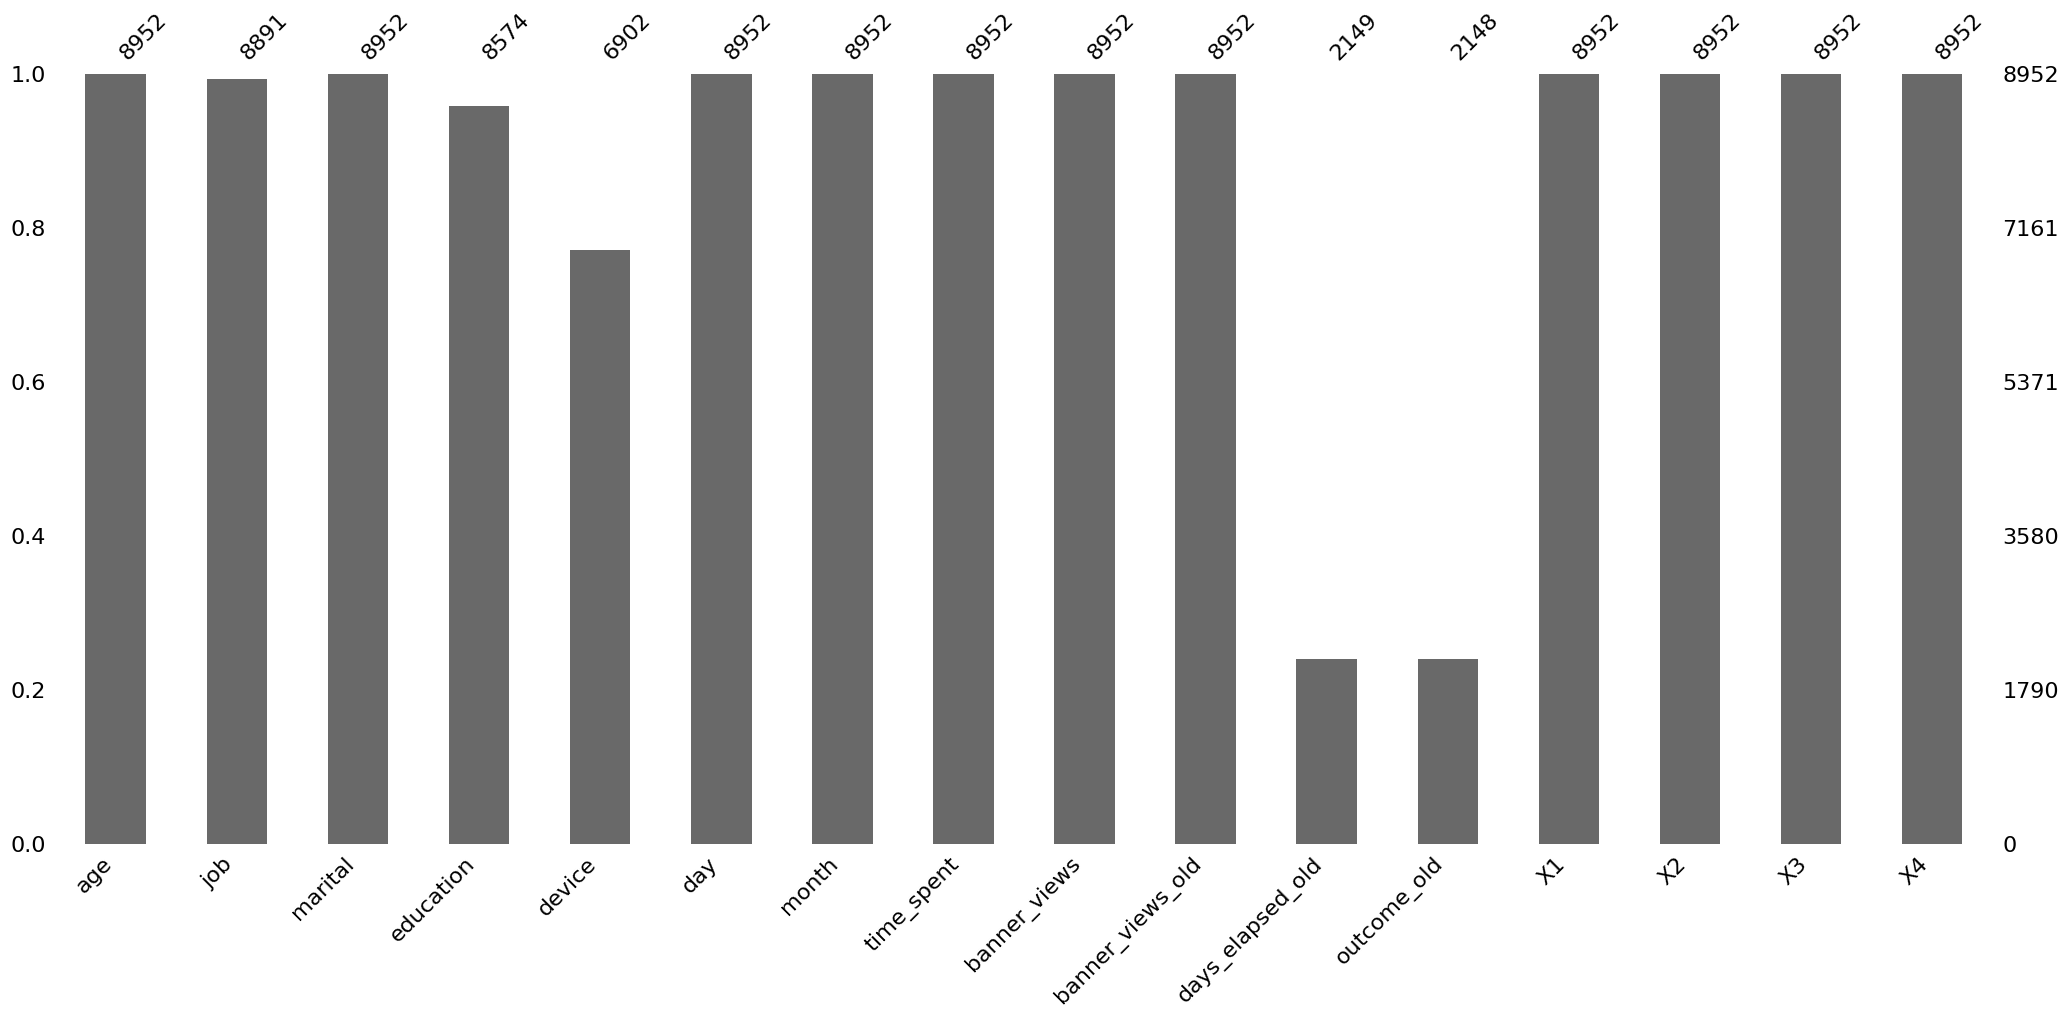

In [97]:
msno.bar(train)

It can be seen that job, education, device, outcome_old and days_elapsed_old have missing data. For the cateogrical data the values could maybe just be replaced by a missing indicator but not for the numerical data. We also see that the days_elapsed_old and outcome_old column seem to have the exact same amount of missing data. To check whether the missingness between these columns are linked we check the case whise missing data plot. 

<Axes: >

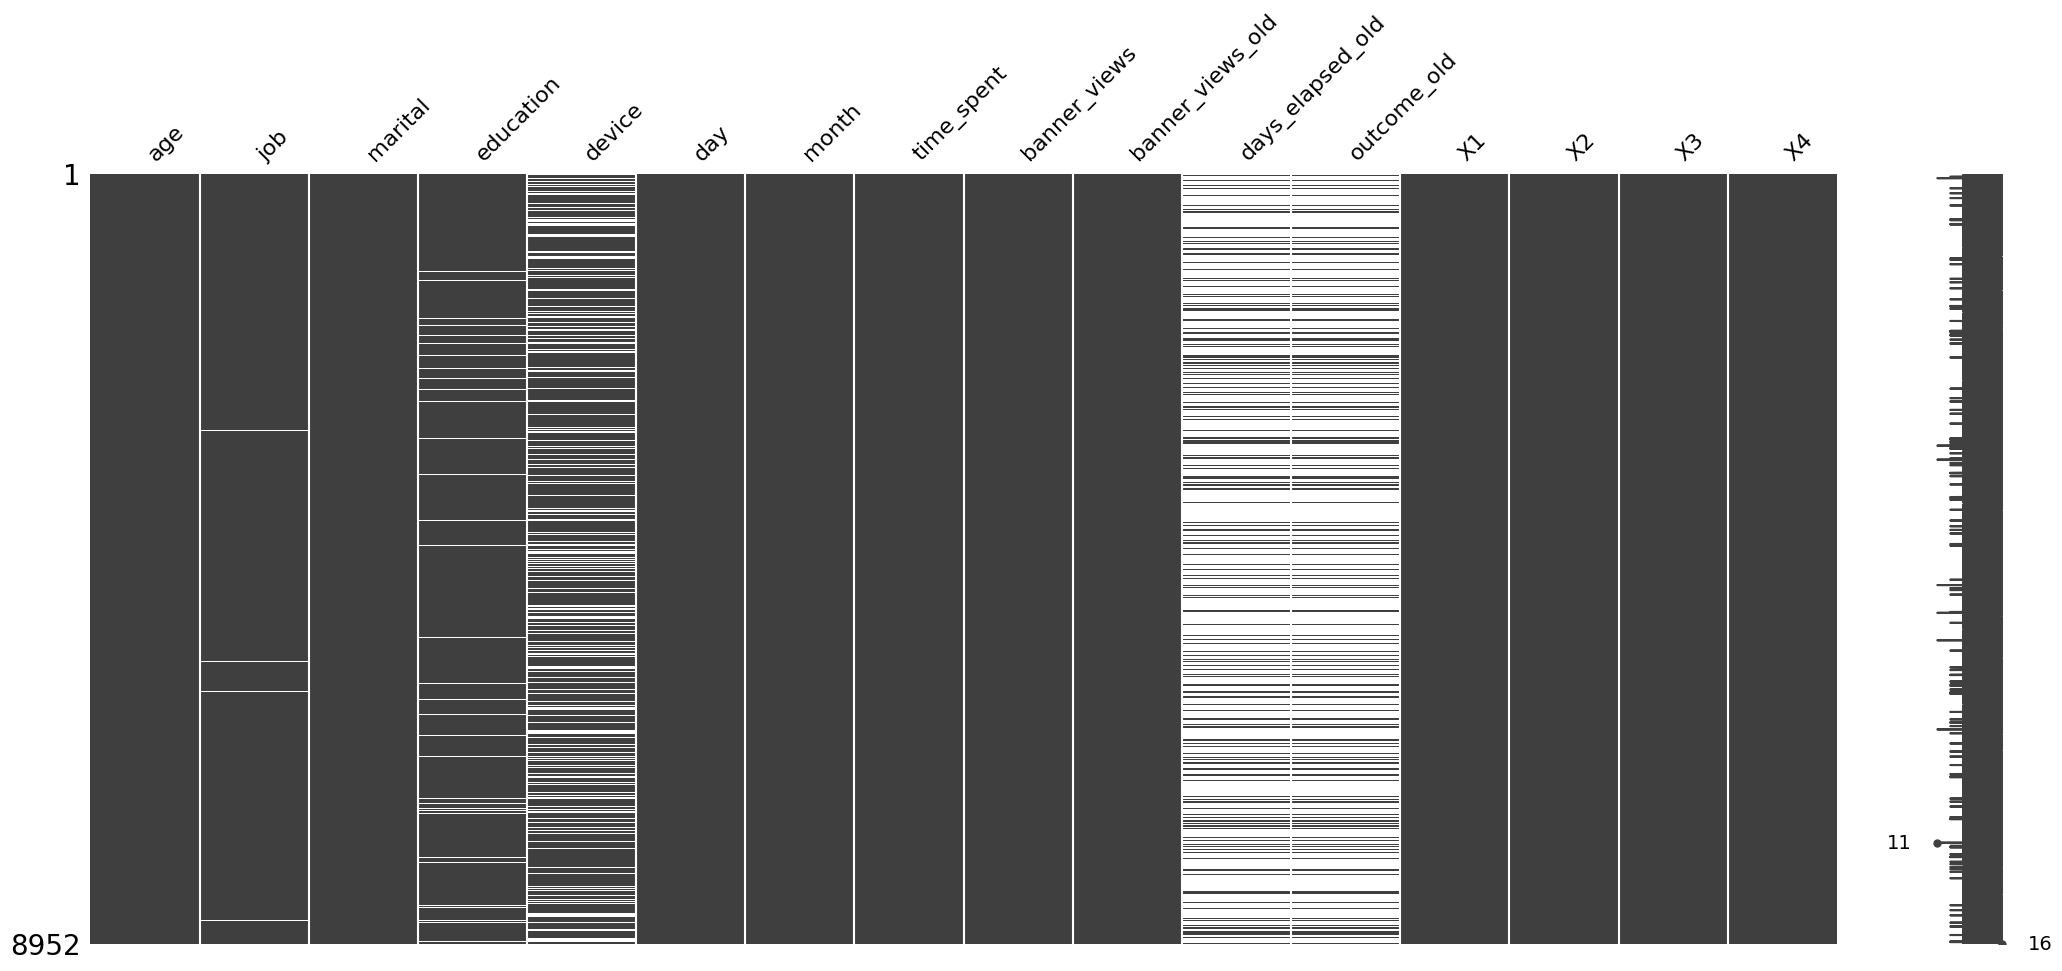

In [98]:
msno.matrix(train)

One can see on the sparkline on the right that the most missing values in a row are 5 columns that are missing and that most of the data has a value in every column.

It can be seen that days_elapsed_old and outcome_old are missing jointly. When we think about imputing these missing values we would like to use KNNImputer for the days_elapsed_old column as it would predict which value would most likely be used. But this would mean that the outcome_old would also have to be imputed with KNNImputer. This on the other hand does not work with KNNImputer as outcome_old is categorical data. What we could do is transform the categories to ordinal ones first and then fit the KNNImputer

In [99]:
# Encoding categories ordinal
enc = OrdinalEncoder()
temp1 = pd.DataFrame(enc.fit_transform(train), columns=list(train.columns))

# Imputing with KNN
imputer = KNNImputer(n_neighbors=5, weights="uniform")
temp2 = pd.DataFrame(imputer.fit_transform(temp1), columns=list(train.columns))

# Decode categories
train = pd.DataFrame(enc.inverse_transform(temp2),  columns=list(train.columns))


# Encoding categories ordinal
enctest = OrdinalEncoder()
temp1test = pd.DataFrame(enctest.fit_transform(test), columns=list(test.columns))

# Imputing with KNN
imputertest = KNNImputer(n_neighbors=5, weights="uniform")
temp2test = pd.DataFrame(imputertest.fit_transform(temp1test), columns=list(test.columns))

# Decode categories
test = pd.DataFrame(enctest.inverse_transform(temp2test),  columns=list(test.columns))

With all missing values imputed we can now do some plots to further look at the data. 

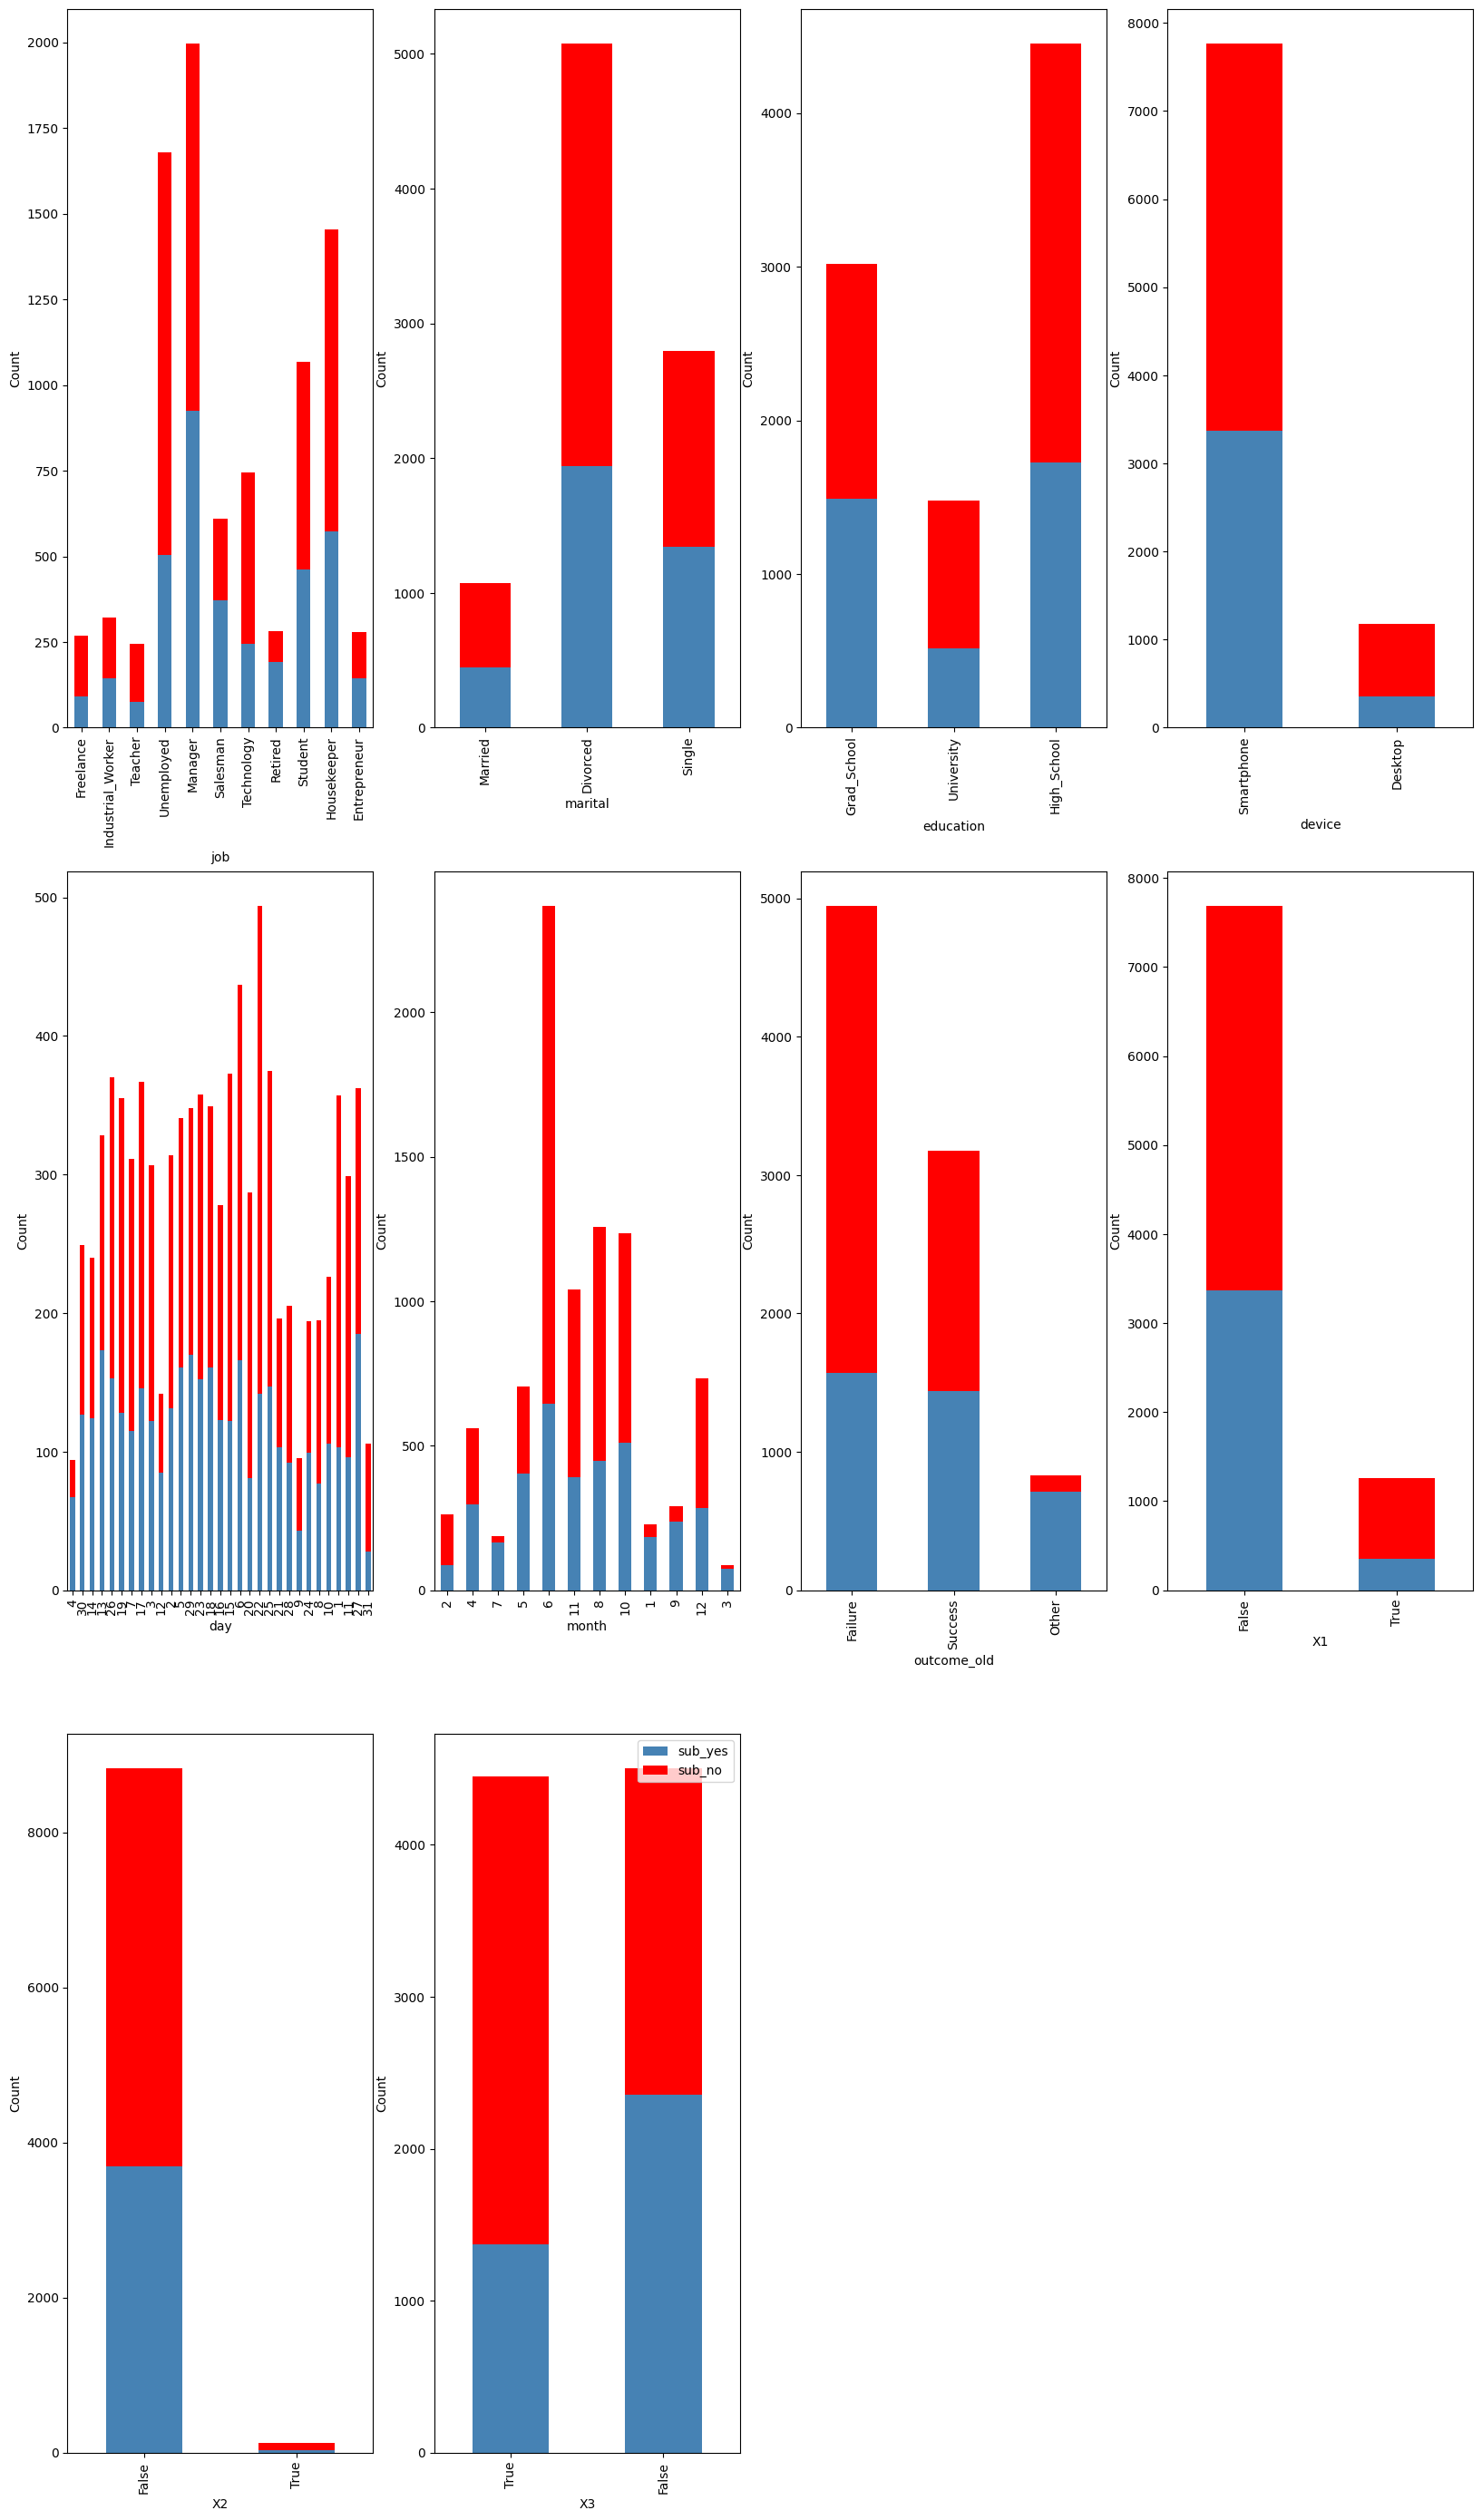

In [100]:
plt.figure(figsize=(20,35))
trainwithsub = pd.concat([train, y_train], axis=1)
for i, col in enumerate(categorical_columns_names):
    ax = plt.subplot(3, 4, i+1)
    unique_values = [str(s).title() for s in trainwithsub[col].value_counts(dropna=False, sort=False).index]
    sub_yes = trainwithsub[col][trainwithsub.subscription == True].value_counts(dropna=False, sort=False)
    sub_no = trainwithsub[col][trainwithsub.subscription == False].value_counts(dropna=False, sort=False)
    temp = pd.DataFrame({'unique':unique_values,
                         'sub_yes':sub_yes,
                         'sub_no':sub_no})
    temp.plot(kind='bar', stacked=True, color=['steelblue', 'red'], ax=ax, legend = None)
    plt.xticks(range(len(unique_values)), unique_values, rotation=90)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.legend()
plt.show()

We see that there is no clear indicator for subscription in the categorical variable. One could maybe think about scraping X2 as there are very few True values. 

Using the ordinal data from before we can also plot a correlation matrix for the whole data set (Instead of just the numerical values) and also a pairs plot for all variables. 

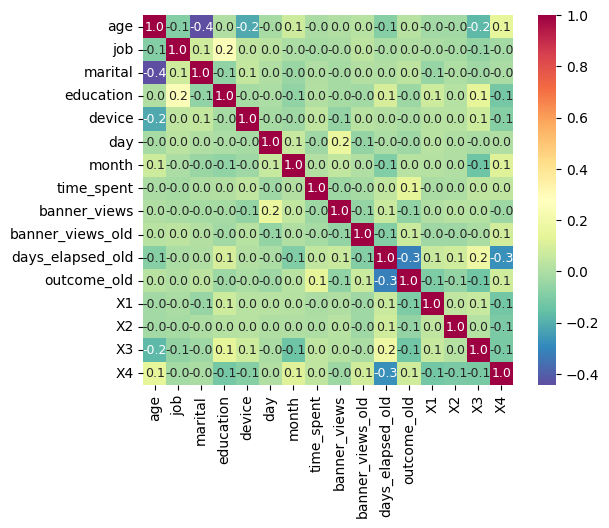

In [101]:
corrmat = temp2.corr(numeric_only=True, )
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.1f', 
                 annot_kws={'size': 9}, 
                 cmap="Spectral_r")
plt.show()

We see that there are no large correlations. The biggest one is between the categorical variable martial and age. This make sense as people who are older are more likely to be married. Simultaneously days_elapsed_old and outcome_old are correlated with -0.3 and so is days_elapsed_old with X4.

We can now also plot a pairsplot (with the ordinal data) to see the relationship between variables and to see if they are seperable when looking at subbing or not. 

In [102]:
# trainwithsub = pd.concat([temp2, y_train], axis=1)
# g = sns.PairGrid(trainwithsub, diag_sharey=False, hue='subscription')
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)

From the pairslot one can see that the Data is not easily seperable. To get better sepearability we can try squaring the data. Cubing shouldn't do anything as there are no negative values in the data. But before we do that we need to dummify the categorical data

In [103]:
train = train.astype({'X1':'int64', 'X2':'int64', 'X3':'int64', 'age':'float64', 'time_spent':'float64', 'banner_views':'float64', 'banner_views_old':'float64', 'days_elapsed_old':'float64', 'X4':'float64'})
train = pd.get_dummies(train, dummy_na=True)

test = test.astype({'X1':'int64', 'X2':'int64', 'X3':'int64', 'age':'float64', 'time_spent':'float64', 'banner_views':'float64', 'banner_views_old':'float64', 'days_elapsed_old':'float64', 'X4':'float64'})
test = pd.get_dummies(test, dummy_na=True)

C:\Users\micha\AppData\Local\Temp\ipykernel_6508\4135050362.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  train = pd.get_dummies(train, dummy_na=True)
C:\Users\micha\AppData\Local\Temp\ipykernel_6508\4135050362.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  train = pd.get_dummies(train, dummy_na=True)
C:\Users\micha\AppData\Local\Temp\ipykernel_6508\4135050362.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test = pd.get_dummies(test, dummy_na=True)
C:\Users\micha\AppData\Local\Temp\ipykernel_6508\4135050362.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavio

With the dummifyed data we can now add squared variables

In [84]:
train
# poly = PolynomialFeatures(2, interaction_only=False)
# poly.fit_transform(test)
# train = pd.DataFrame(poly.fit_transform(train), columns=poly.get_feature_names_out())
# test = pd.DataFrame(poly.fit_transform(test), columns=poly.get_feature_names_out())

In [87]:
train.shape

(8952, 3403)

In [69]:
from sklearn.linear_model import LogisticRegression, Lasso

LR = LogisticRegression()
LR.fit(train, y_train)

predictionsLR = LR.predict(test)
LR.score(train,y_train)


0.8346738159070599

In [83]:
lasso = Lasso(alpha = 0)
lasso.fit(train,y_train)
train_score_ls =lasso.score(train,y_train)
train_score_ls

C:\Users\micha\AppData\Local\Temp\ipykernel_6508\1756748822.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(train,y_train)
c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.127e+02, tolerance: 2.175e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV i

0.4367616184131552